### 1. Importing packages

In [ ]:
!pip install shap

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# no warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# displaying up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# setting default font size
plt.rcParams['font.size'] = 24

# internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# splitting, preprocessing, and cross-validating data into training and testing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# XGBoost for machine learning
from xgboost import XGBClassifier

# for Explainable AI
import shap

### 2. Loading dataset and Feature engineering

In [ ]:
# reading credit into a dataframe

credit = pd.read_csv('credit_data.csv')
credit.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [ ]:
# verifying the column data types and non-missing values

credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [ ]:
# deleting useless features

credit.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

In [ ]:
# calculating missing values by column for verifying data preprocessing results

def missing_values_table(df):
    # total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # making a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # renaming the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # sorting the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # printing some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    # returning the dataframe with missing information
    return mis_val_table_ren_columns

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


,Missing Values,% of Total Values


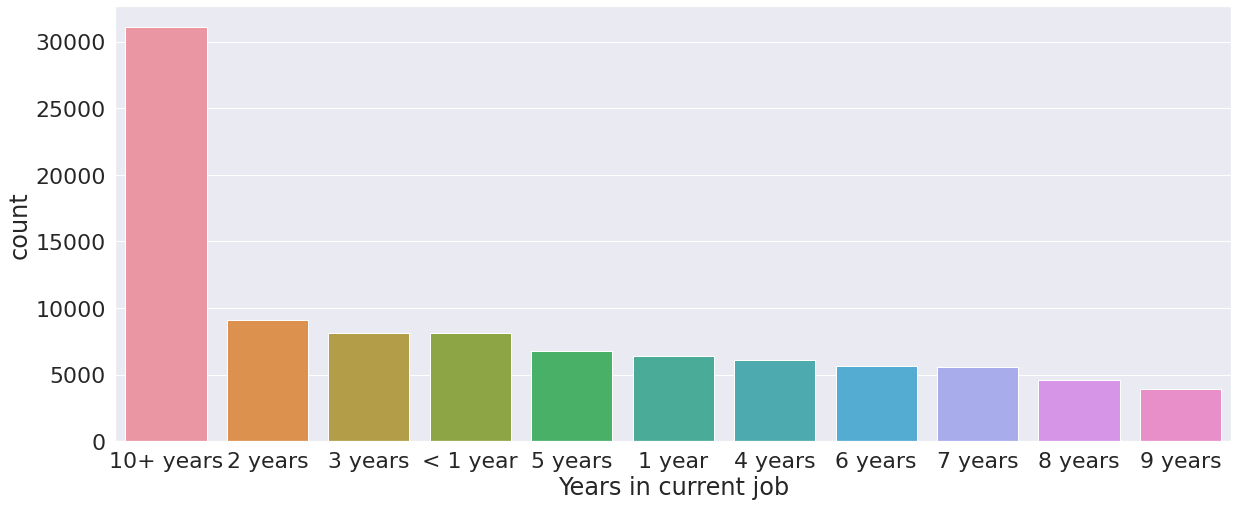

In [ ]:
# dropping the columns with > 50% missing
credit.drop(columns = 'Months since last delinquent', axis=1, inplace=True)
credit[credit['Years of Credit History'].isnull() == True]

# last 514 observations are NaN values

credit.drop(credit.tail(514).index, inplace=True) # dropping last 514 rows

# number of missing values is so low in 'Maximum Open Credit', 'Tax Liens', 'Bankruptcies'

for i in credit['Maximum Open Credit'][credit['Maximum Open Credit'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

for i in credit['Tax Liens'][credit['Tax Liens'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

for i in credit['Bankruptcies'][credit['Bankruptcies'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

credit.fillna(credit.mean(), inplace=True)

plt.figure(figsize=(20,8))
sns.countplot(credit['Years in current job'], order = credit['Years in current job'].value_counts().index)

credit.fillna('10+ years', inplace=True) # fill with '10+ years'
missing_values_table(credit)


### 3. Feature engineering and selection

In [ ]:
credit.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [ ]:
# encoding categorical data & feature scaling

# selecting the categorical columns
categorical_subset = credit[['Term', 'Years in current job', 'Home Ownership', 'Purpose']]

# one hot encoding
categorical_subset = pd.get_dummies(categorical_subset)

# joining the dataframe in credit_train
credit.drop(labels=['Term', 'Years in current job', 'Home Ownership', 'Purpose'], axis=1, inplace=True)
credit = pd.concat([credit, categorical_subset], axis = 1)

In [ ]:
# removing collinear features

def remove_collinear_features(x, threshold):
    # not removing correlations between Energy Star Score
    y = x['Loan Status']
    x = x.drop(columns = ['Loan Status'])
    
    # calculating the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # iterating through the correlation matrix and comparing correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # if correlation exceeds the threshold
            if val >= threshold:
                # printing the correlated features and the correlation values
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # dropping one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # adding the score back in to the data
    x['Loan Status'] = y
               
    return x

In [ ]:
# removing the collinear features above a specified correlation coefficient

credit = remove_collinear_features(credit, 0.6);

In [ ]:
credit.shape

(99794, 42)

In [ ]:
credit.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status
0,445412.0,709.000000,1.167493e+06,5214.74,17.2,6.0,1.0,228190.0,416746.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Fully Paid
1,262328.0,1076.275101,1.378339e+06,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
2,99999999.0,741.000000,2.231892e+06,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
3,347666.0,721.000000,8.069490e+05,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
4,176220.0,1076.275101,1.378339e+06,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid


### 4. XGBoost classification

In [ ]:
# splitting into training and testing sets

# separating out the features and targets
features = credit.drop(columns='Loan Status')
targets = pd.DataFrame(credit['Loan Status'])

# splitting into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79835, 41)
(19959, 41)
(79835, 1)
(19959, 1)


In [ ]:
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# encoding the dependent variable
labelencoder_y_train = LabelEncoder()
y_train = labelencoder_y_train.fit_transform(y_train)
labelencoder_y_test = LabelEncoder()
y_test = labelencoder_y_test.fit_transform(y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
def cross_val(X_train, y_train, model):
    # applying k-Fold cross validation
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

# taking in a model, training the model, and evaluating the model on the test set
def fit_and_evaluate(model):
    # training the model
    model.fit(X_train, y_train)
    
    # making predictions and evaluting
    model_pred = model.predict(X_test)
    model_cross = cross_val(X_train, y_train, model)
    
    # returning the performance metric
    return model_cross

In [ ]:
# XGBoost classification
gb = XGBClassifier()
gb_cross = fit_and_evaluate(gb)

print('XGBoost Classification Performance on the test set: Cross Validation Score = %0.4f' % gb_cross)

XGBoost Classification Performance on the test set: Cross Validation Score = 0.8198


In [ ]:
model = XGBClassifier(loss = 'ls', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 2,
                                  max_features = 'auto',
                                  n_estimators = 500,
                                  random_state = 42)

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, loss='ls', max_delta_step=0, max_depth=5,
              max_features='auto', min_child_weight=1, min_samples_leaf=6,
              min_samples_split=2, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
final_pred = model.predict(X_test)

# calculating mean absolute error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred))

Model performance on the test set:   MSE = 0.1814.


In [ ]:
# feature importances

# extracting the feature importances into a dataframe
feature_results = pd.DataFrame({'Feature': list(features.columns), 
                                'Importance': model.feature_importances_})

# showing the top 10 most important
feature_results = feature_results.sort_values('Importance', ascending = False).reset_index(drop=True)
feature_results['Rank'] = np.arange(1, len(feature_results)+1, 1)
feature_results_rank = feature_results.set_index('Rank')
feature_results_rank = feature_results_rank[['Feature', 'Importance']]
feature_results_rank.head(10)

,Feature,Importance
Rank,,
1,Credit Score,0.244674
2,Term_Long Term,0.110849
3,Current Loan Amount,0.066993
4,Purpose_Business Loan,0.032669
5,Home Ownership_Home Mortgage,0.030766
6,Annual Income,0.025142
7,Purpose_small_business,0.024693
8,Purpose_Home Improvements,0.019140
9,Tax Liens,0.019057


In [ ]:
# using feature importances for feature selection

# extracting the names of the most important features
most_important_features = feature_results['Feature'][:10]

# finding the index that corresponds to each feature name
indices = [list(features.columns).index(x) for x in most_important_features]

# keeping only the most important features
X_train_reduced = X_train[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_train_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (79835, 10)
Most important testing  features shape:  (19959, 10)


In [ ]:
# creating the model with the same hyperparamters
model_reduced = XGBClassifier(loss='ls', max_depth=5, max_features='auto',
                                  min_samples_leaf=6, min_samples_split=2, 
                                  n_estimators=500, random_state=42)

# fitting and testing on the reduced set of features
model_reduced.fit(X_train_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('XGBoost Reduced Results: MSE = %0.4f' % mse(y_test, model_reduced_pred))

XGBoost Reduced Results: MSE = 0.1830


In [ ]:
# mending the data for calculating and plotting Sharpley values
X_train = pd.DataFrame(X_train)
X_train.columns = features.columns
X_train.rename(columns = {'Years in current job_< 1 year':'Years in current job less than a year'}, inplace = True)
X_train.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job less than a year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,-0.361023,-0.290981,0.528583,0.816073,-0.711771,1.372703,-0.351741,-0.264319,-0.050631,-0.115346,1.614134,-1.614134,-0.262214,-0.739784,-0.316354,-0.297815,3.912736,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
1,-0.355234,-0.261657,0.484072,0.163251,0.428567,-0.624846,-0.351741,0.113466,-0.025323,-0.115346,-0.619527,0.619527,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,-0.968760,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
2,-0.357882,-0.261657,-0.358240,-0.179778,-0.113094,0.373928,-0.351741,0.063415,-0.026209,-0.115346,1.614134,-1.614134,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
3,2.781259,-0.251882,-0.316233,-0.487218,1.397854,0.973193,-0.351741,0.377486,0.096925,-0.115346,1.614134,-1.614134,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
4,2.781259,-0.255642,-0.634944,0.090544,-0.127348,-0.225336,-0.351741,-0.193216,-0.037176,-0.115346,-0.619527,0.619527,3.813686,-0.739784,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,-0.968760,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334


In [ ]:
idx = 14

### 5. Visualization

In [ ]:
# loading JS visualization code to notebook
shap.initjs()

# explaining the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualizing the first prediction's explanation
# use matplotlib=True to avoid Javascript
shap.force_plot(explainer.expected_value, 
                shap_values[idx,:], 
                X_train.iloc[idx,:])

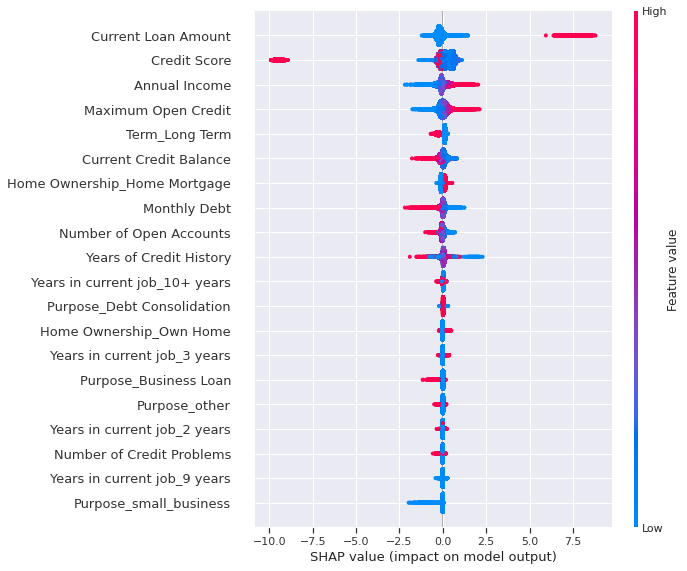

In [ ]:
# summarizing the effects of all the features
shap.summary_plot(shap_values, X_train)

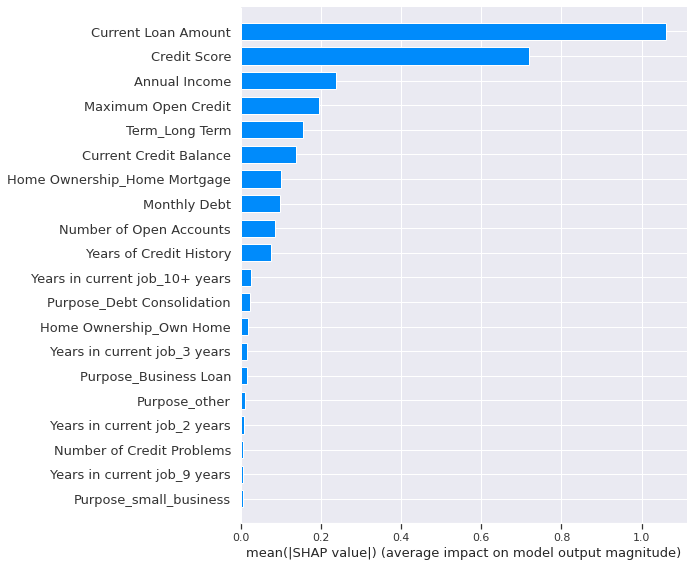

In [ ]:
# summarizing the importance of the features
shap.summary_plot(shap_values, X_train, plot_type="bar")